# Word Embeddings using GloVe

- GloVe: Global Vectors for Word Representation
- It is another algorithm for finding word vectors
- Compared to word2vec, Glove is simpler, easier to train and no tricks are used. 
- Glove is based on Matrix factorization, a common algorithm in Recommender Systems.


## Recommender Systems

### Basic concepts

- Having users, movies and some ratings user gave of movies they watched. 
- We can predict the rating of movies a user has not seen yet.
- User-Movie Ratings Matrix:
    - N users <-> N rows
    - M items <-> M columns
    - shape(R) = N x M
    - `R[i][j]` = Rating of user `i` about ~~movie~~ item `j`.
    - Most values are empty. 
        - Sparse matrix
        - Not meaning full of zeroes
        - It is just that values are missing
- Matrix Factorization is a classic algorithm of **Collaborative filtering**, in which other user's data is used to make predictions for a specific user. 
- User-Movie Rating Matrix can be transformed into a term document matrix in NLP
    - N words <-> N rows
    - M documents <-> M documents
    - shape(R) = N x M
    - `R[i][j]` = Number of times word `i` appears in document `j`.
- Redundancy, i.e. the existance of two or more features very correlated with each other, is the key property of these matrices.
- Using redundancy, we need to reduce dimensionality of the data. One way is using SVD (singular value decomposition)

$$X = USV^T$$

- Reduction in shapes, using $K << D$, and an approximation: 

$$\hat{X}_{NxD} = U_{NxK} S_{KxK} V^T_{KxD}$$

- SVD does not work for recommender systems, since it hs missing values.
- Here is where **matrix factorization** enters into play.

### Matrix factorization

- After seeing with SVD that it is possible to factorize a matrix, we want to factorize R into just two matrices: 

$$R \approx \hat{R} = W U^T$$

- With dimensions: 

$$R_{NxM} \approx \hat{R}_{NxM} = W_{NxK} U^T_{KxM}$$

- Each individual prediction is just a simple dot product between 2 K-length vectors

$$ \hat{r}_{ij} = W^T_i U_j $$

#### Model evaluation

- Let $\Omega$ be the set of pairs $(i, j)$ where user $i$ rated movie $j$.
- Error is the squared error on known ratings: 

$$ J = \sum_{i,j \in \Omega} (r_{ij} - \hat{r}_{ij})^2 $$

- More symbols: 
    - Let $\Omega_j$ be the set of users $i$ who rated movie $j$.
    - Let $\Psi_i$ set of movies $j$ which user $i$ rated.
    
    
#### Training

- Gradient for $w_i$: 
    - `Ax = b`
    - In code use `x = np.linalg.solve(A, b)`

$$ w_i = \left( \sum_{j \in \Psi_i} u_j u_j^T \right)^{-1} \sum_{j \in \Psi_i} r_{ij} u_j $$

- Gradient for $u_j$:

$$ u_j = \left( \sum_{i \in \Omega_j} w_i w_i^T \right)^{-1} \sum_{i \in \Omega_j} r_{ij}w_i $$

- There is a two way dependency, i.e. for solving $w$ we need $u$, and vice versa.
    - During training phase, both $U$ and $W$ will be updated simultaneously. 
    - First, update $W$
    - Second, update $U$ (use new values in $W$)
    - Finally, update $W$ again. (use new values in $U$)
    - This is called "Alternating least squares".
        - Order of updates does not matter. 


#### Expanding model

- Need for bias terms:
    - Remember bias, in linear regression, is the `b` in `y = mx + b`.
    - User ratings are not consistent, i.e. different people rate things differently.
    - In a 5 star rate some users may think: 
        - 2.5 is average
        - 2.5 is bad
        - 4.5 is bad
        - 4.5 is good
    - Some users are optimistic or pessimistic

- New model equation: 
    - $b_i$ is the user bias, (already discussed)
    - $c_j$ is the movie bias, 
    - $\mu$ is the global average, used to shift the values of ratings so its mean is zero.
$$ \hat{r}_{ij} = w_i^T u_j + b_i + c_j + \mu $$

- New gradients considering biases: 
    - No need to update $\mu$ because it can be calculated directly from train dada.  

$$ w_i = \left( \sum_{j \in \Psi_i} u_j u_j^T \right)^{-1} \sum_{j \in \Psi_i} (r_{ij} - b_i - c_j - \mu) u_j $$

$$ u_j = \left( \sum_{i \in \Omega_j} w_i w_i^T \right)^{-1} \sum_{i \in \Omega_j} (r_{ij} - b_i - c_j - \mu) w_i $$

$$ b_i = \frac{1}{|\Psi_i|} \sum_{j \in \Psi_i} (r_{ij} - w_i^T u_j - c_j - \mu ) $$

$$ c_j = \frac{1}{|\Omega_j|} \sum_{i \in \Omega_j} (r_{ij} - w_i^T u_j - b_i - \mu) $$

#### Regularization

- New error formula: 
    - $\lambda$ importance of regularization
    - $||*||_F$ is called _Forbenius norm_

$$ J = \sum_{i,j \in \Omega} (r_{ij} - \hat{r}_{ij})^2 + \lambda(||W||_F^2 + ||U||_F^2 + ||b||_F^2 + ||c||_F^2)$$

- New gradients: 

$$ w_i = \left( \sum_{j \in \Psi_i} u_j u_j^T + \lambda I \right)^{-1} \sum_{j \in \Psi_i} (r_{ij} - b_i - c_j - \mu) u_j $$

$$ u_j = \left( \sum_{i \in \Omega_j} w_i w_i^T + \lambda I \right)^{-1} \sum_{i \in \Omega_j} (r_{ij} - b_i - c_j - \mu) w_i $$

$$ b_i = \frac{1}{|\Psi_i|+\lambda} \sum_{j \in \Psi_i} (r_{ij} - w_i^T u_j - c_j - \mu ) $$

$$ c_j = \frac{1}{|\Omega_j|+\lambda} \sum_{i \in \Omega_j} (r_{ij} - w_i^T u_j - b_i - \mu) $$


## Implementing GloVe

- Transform data to match matrix factorization X.
- Build a term by term matrix where `X[i][j]` is bigger if word `i` appears in context of word `j`, smaller if not. 

### Build term by term matrix

- Context distance: 
    - Given a sentence: $w_0, w_1, ..., w_{n-1}$
    - Given a context window.
    - `X[w0][w1] += 1`
    - `X[w0][w2] += 1/2`
    - `X[w0][w3] += 1/3`
    ...
- Sparse matrix, filled with zeros, not like in recommender systems.
- Values can be very large, so taking `log` will be a benefit. 
    - Add 1 before applying `log` (to avoid NaNs)

- Weight every pair `(i, j)` like so: 
    - $\alpha = 0.75$
    - $X_{max} = 100$
    - $f(X) = (\frac{X}{X_{max}})^\alpha$ if $X < X_{max}$ else 1
    
$$ J = \sum_i \sum_j f(X_{ij})(w_i^T u_j + b_i + c_j + \mu - log X_{ij})^2 $$

$$ log X_{ij} \simeq w_i^T u_j + b_i + c_j + \mu $$

- Gradients

$$ w_i = \left( \sum_j f(X_{ij}) u_j u_j^T \right)^{-1} \sum_j f(X_{ij})(log X_{ij} - b_i - c_j - \mu) u_j $$

$$ u_j = \left( \sum_i f(X_{ij}) w_i w_i^T \right)^{-1} \sum_i f(X_{ij})(log X_{ij} - b_i - c_j - \mu) w_i $$

$$ b_i = \frac{1}{\sum_j f(X_{ij})} \sum_j f(X_{ij})(log X_{ij} - w_i^T u_j - c_j - \mu) $$

$$ c_j = \frac{1}{\sum_i f(X_{ij})} \sum_i f(X_{ij})(log X_{ij} - w_i^T u_j - b_i - \mu) $$

In [33]:
import sys
import os
import time
from nltk.corpus import brown
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.abspath('../vendor/machine_learning_examples'))
from rnn_class.util import get_wikipedia_data
from rnn_class.brown import get_sentences_with_word2idx_limit_vocab
from nlp_class2.util import find_analogies

from sklearn.manifold import TSNE

In [3]:
def get_context_with_distance(pos, sentence, window):
    wordsWithDistance = []
    deltas = range(-window, window+1)
    for d in deltas:
        curPos = pos + d
        if d != 0 and curPos >= 0 and curPos < len(sentence):
            wordsWithDistance.append((sentence[curPos], d))
    return wordsWithDistance

In [4]:
def build_matrix_x_old(V, window, sentences, startIdx = 0, endIdx = 1):
    X = np.ones([V, V], np.float32) # V x V
    for sentence in sentences: 
        sentence = [startIdx] + sentence + [endIdx]
        for curPos in range(len(sentence)):
            curWord = sentence[curPos]
            contextWords = get_context_with_distance(curPos, sentence, window)
            for ctxWord, dist in contextWords:
                X[curWord][ctxWord] += 1.0 / np.abs(dist)
                X[ctxWord][curWord] += 1.0 / np.abs(dist)
    X = np.log(X)
    return X

In [5]:
def build_matrix_x(V, context_sz, sentences):
    X = np.zeros((V, V))
    N = len(sentences)
    print("number of sentences to process:", N)
    it = 0
    for sentence in sentences:
        it += 1
        if it % 10000 == 0:
            print("processed", it, "/", N)
        n = len(sentence)
        for i in range(n):
            # i is not the word index!!!
            # j is not the word index!!!
            # i just points to which element of the sequence (sentence) we're looking at
            wi = sentence[i]

            start = max(0, i - context_sz)
            end = min(n, i + context_sz)

            # we can either choose only one side as context, or both
            # here we are doing both

            # make sure "start" and "end" tokens are part of some context
            # otherwise their f(X) will be 0 (denominator in bias update)
            if i - context_sz < 0:
                points = 1.0 / (i + 1)
                X[wi,0] += points
                X[0,wi] += points
            if i + context_sz > n:
                points = 1.0 / (n - i)
                X[wi,1] += points
                X[1,wi] += points

            # left side
            for j in range(start, i):
                wj = sentence[j]
                points = 1.0 / (i - j) # this is +ve
                X[wi,wj] += points
                X[wj,wi] += points

            # right side
            for j in range(i + 1, end):
                wj = sentence[j]
                points = 1.0 / (j - i) # this is +ve
                X[wi,wj] += points
                X[wj,wi] += points
    return X

In [6]:
%%capture
# brown
keep_words = set([
    'king', 'man', 'woman',
    'france', 'paris', 'london', 'rome', 'italy', 'britain', 'england',
    'french', 'english', 'japan', 'japanese', 'chinese', 'italian',
    'australia', 'australian', 'december', 'november', 'june',
    'january', 'february', 'march', 'april', 'may', 'july', 'august',
    'september', 'october',
])
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(
    n_vocab=5000,
    keep_words=keep_words
)
idx2word = {v:k for k,v in word2idx.items()}

In [5]:
%%capture
# wikipedia
wikiSentences, wikiWord2idx = get_wikipedia_data(
    n_files=50, 
    n_vocab=5000
)

In [26]:
V = len(word2idx) # vocabulary size
K = 100 # size of internal vectors
window = 2 # context size
Xmax = 100 # weight function parameter
alpha = 0.75 # weight function parameter
lr = 1e-4 # learning rate
reg = 0.1 # regularization lambda
epochs = 200 # training epochs

In [8]:
t0 = time.time()
X = build_matrix_x(V, window, sentences) # V x V

print("max in X:", X.max())

fX = np.zeros((V, V))
fX[X < Xmax] = (X[X < Xmax] / float(Xmax)) ** alpha
fX[X >= Xmax] = 1

logX = np.log(X + 1)
print("max in log(X):", logX.max())

t1 = time.time()
print("Building time: " + str(t1-t0))

number of sentences to process: 57013
processed 10000 / 57013
processed 20000 / 57013
processed 30000 / 57013
processed 40000 / 57013
processed 50000 / 57013
max in X: 87101.0
max in log(X): 11.374835124689483
Building time: 8.671939849853516


In [17]:
W = np.random.randn(V, K) / np.sqrt(V+K)   # V x K
U = np.random.randn(V, K) / np.sqrt(V+K)   # V x K
b = np.zeros(V)       # V
c = np.zeros(V)       # V
mu = logX.mean()      # scalar

In [27]:
tf.reset_default_graph()
tfLogX = tf.placeholder(tf.float32, shape=[V, V])
tffX = tf.placeholder(tf.float32, shape=[V, V])
tfW = tf.Variable(W.astype(np.float32))
tfU = tf.Variable(U.astype(np.float32))
tfb = tf.Variable(b.astype(np.float32))
tfc = tf.Variable(c.astype(np.float32))

In [28]:
# Cost function
delta = tf.matmul(tfW, tf.transpose(tfU)) + tfb + tfc + mu - tfLogX
cost = tf.reduce_sum(tffX * delta * delta)
regularized_cost = cost
for param in (tfW, tfU):
    regularized_cost += reg*tf.reduce_sum(param * param)

In [29]:
# train = tf.train.AdamOptimizer(learning_rate=lr).minimize(regularized_cost)
train = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9).minimize(regularized_cost)

In [30]:
init = tf.global_variables_initializer()

Epoch 0/200
	Cost: 485425.0
Epoch 10/200
	Cost: 241786.3
Epoch 20/200
	Cost: 160046.02
Epoch 30/200
	Cost: 101956.79
Epoch 40/200
	Cost: 63756.324
Epoch 50/200
	Cost: 48343.723
Epoch 60/200
	Cost: 41005.938
Epoch 70/200
	Cost: 36729.004
Epoch 80/200
	Cost: 33645.38
Epoch 90/200
	Cost: 31094.252
Epoch 100/200
	Cost: 28941.785
Epoch 110/200
	Cost: 27040.227
Epoch 120/200
	Cost: 25298.572
Epoch 130/200
	Cost: 23736.047
Epoch 140/200
	Cost: 22356.016
Epoch 150/200
	Cost: 21123.865
Epoch 160/200
	Cost: 20010.379
Epoch 170/200
	Cost: 18999.324
Epoch 180/200
	Cost: 18080.363
Epoch 190/200
	Cost: 17244.695
Training time: 199.05724596977234


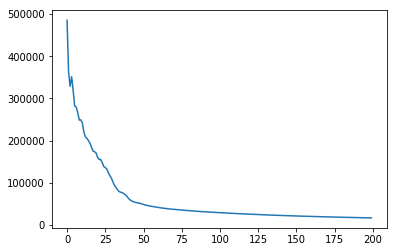

In [31]:
costs = []
t0 = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        train_cost, _ = sess.run(
            [regularized_cost, train], 
            feed_dict={
                tfLogX: logX,
                tffX: fX,
            }
        )
        costs.append(train_cost)
        if epoch % 10 == 0:
            print("Epoch %s/%s" % (epoch, epochs))
            print("\tCost: %s" % train_cost)
    modelW, modelU = sess.run([tfW, tfU])

t1 = time.time()
print("Training time: " + str(t1-t0))
plt.plot(costs)

In [32]:
modelW # V x K
modelU # V x K

for concat in (True, False):
    print("** concat:", concat)

    if concat:
        We = np.hstack([modelW, modelU])
    else:
        We = (modelW + modelU) / 2


    find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
    find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
    find_analogies('france', 'french', 'english', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
    find_analogies('december', 'november', 'june', We, word2idx, idx2word)

** concat: True
closest match by euclidean distance: towards
king - man = towards - woman
closest match by cosine distance: grand
king - man = grand - woman
closest match by euclidean distance: poetry
france - paris = poetry - london
closest match by cosine distance: 1961
france - paris = 1961 - london
closest match by euclidean distance: europe
france - paris = europe - rome
closest match by cosine distance: europe
france - paris = europe - rome
closest match by euclidean distance: reflected
paris - france = reflected - italy
closest match by cosine distance: reflected
paris - france = reflected - italy
closest match by euclidean distance: europe
france - french = europe - english
closest match by cosine distance: america
france - french = america - english
closest match by euclidean distance: somewhere
japan - japanese = somewhere - chinese
closest match by cosine distance: somewhere
japan - japanese = somewhere - chinese
closest match by euclidean distance: february
japan - japanese

In [110]:
def get_related_words(word, We, word2idx, idx2word):
    if word not in word2idx:
        word = 'UNKNOWN'
    wordIdx = word2idx[word]
    wordValues = { idx2word[i]: We[wordIdx][i] for i in range(V) }
    return sorted(wordValues.items(), key=lambda kv : (kv[1], kv[0]), reverse=True)

In [111]:
length = 10
curWord = 'START'
sentence = []
for i in range(length):
    curWord = get_related_words(curWord, We, word2idx, idx2word)[0][0]
    sentence.append(curWord)
sentence

['with',
 'head',
 '5',
 'physical',
 'wondered',
 'negroes',
 'p.m.',
 'uncle',
 'earth',
 'phil']

In [112]:
get_related_words('dog', We, word2idx, idx2word)

[('condition', 34.95792),
 ('wanted', 28.247784),
 ('return', 24.408018),
 ('research', 22.956532),
 ('japanese', 22.38609),
 ('told', 22.295786),
 ('instance', 21.799688),
 ('affairs', 21.637226),
 ('is', 21.618036),
 ('mike', 21.396948),
 ('useful', 20.941021),
 ('frequently', 20.687532),
 ('hundred', 20.559444),
 ('extreme', 20.221327),
 ('tell', 20.01563),
 ('possibly', 19.98124),
 ('states', 19.604944),
 ('rich', 19.511276),
 ('piece', 19.47921),
 ('housing', 18.979883),
 ('cells', 18.950865),
 ('study', 18.947908),
 ('generally', 18.65752),
 ('remain', 18.513262),
 ('contact', 18.411636),
 ('at', 18.325823),
 ('completed', 18.09217),
 ('taking', 17.930698),
 ('bodies', 17.836664),
 ('americans', 17.79385),
 ('which', 17.720232),
 ('fully', 17.671032),
 ('created', 17.41642),
 ('going', 17.280952),
 ('bottom', 17.25308),
 ('operating', 17.1399),
 ('best', 17.003504),
 ('concerned', 16.989748),
 ('tomorrow', 16.674232),
 ('primarily', 16.551336),
 ('eat', 16.513866),
 ('benefit', 1

In [36]:
# visualize embeddings
words = list(keep_words)
We = (modelW + modelU) / 2
idx = [word2idx[w] for w in words]
tsne = TSNE()
Z = tsne.fit_transform(We)
Z = Z[idx]

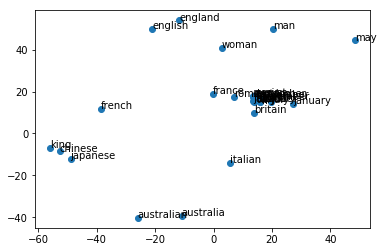

In [39]:
words = list(words)
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))

## Solutions

Numpy: `../vendor/machine_learning_examples/nlp_class2/glove.py`  
TensorFlow: `../vendor/machine_learning_examples/nlp_class2/glove_tf.py`

### Further work

Play with: 
- Learning rate
- Optimizer (momentum may not be the most appropriate one)
- Regularization
- Training data size
- Word embedding size
- Vocabulary size

## GloVe with SVD

- Recall that we didn't use SVD for recommender systems because it needed sparse matrix to not have any missing value. 
- Now in NLP matrices, matrices do not have missing values.
- SVD decomposes a matrix $X$ into three matrices: 
    - $X$ -> N x M
    - $W$ -> N x K
    - $S$ -> K x K
    - $U$ -> M x K
   
$$ X = W S U^T $$

- SVD is not scalable using sklearn.

- We cannot use $f(X)$ as we did in Matrix Factorization. 

- Use `TruncatedSVD`
    - `fix(X)`: find W, S, U
    - `transform(X)`: linear transformation on X: Z = X U

- sklearn does not allow to access W directly, it has to be computed: 
    - $W = Z S^{-1} $
    - U is `model.components_`
    - S is `model.explained_variance_` (diagonal elements only)
        - use `np.diag` to build a matrix with the diagonal elements

### Solution

- Available in file: `../vendor/machine_learning_examples/nlp_class2/glove_svd.py`

(This solution seems to be working better than Matrix Factorization) 

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../vendor/machine_learning_examples/'))
%run -i '../vendor/machine_learning_examples/nlp_class2/glove_svd.py'

reading: enwiki-20181120-pages-articles1-15.txt
reading: enwiki-20181120-pages-articles1-07.txt
reading: enwiki-20181120-pages-articles1-20.txt
reading: enwiki-20181120-pages-articles1-21.txt
reading: enwiki-20181120-pages-articles1-08.txt
reading: enwiki-20181120-pages-articles1-11.txt
reading: enwiki-20181120-pages-articles1-10.txt
reading: enwiki-20181120-pages-articles1-13.txt
reading: enwiki-20181120-pages-articles1-32.txt
reading: enwiki-20181120-pages-articles1-18.txt
reading: enwiki-20181120-pages-articles1-29.txt
reading: enwiki-20181120-pages-articles1-05.txt
reading: enwiki-20181120-pages-articles1-01.txt
reading: enwiki-20181120-pages-articles1-22.txt
reading: enwiki-20181120-pages-articles1-04.txt
reading: enwiki-20181120-pages-articles1-14.txt
reading: enwiki-20181120-pages-articles1-17.txt
reading: enwiki-20181120-pages-articles1-30.txt
reading: enwiki-20181120-pages-articles1-02.txt
reading: enwiki-20181120-pages-articles1-03.txt
reading: enwiki-20181120-pages-articles1

taking 4707
career 4705
artists 4702
compared 4701
simple 4698
chief 4675
f 4671
noted 4660
committee 4660
influenced 4657
heavy 4655
issue 4653
appointed 4649
russia 4646
animals 4645
married 4642
scholars 4642
songs 4642
forced 4639
move 4632
experience 4632
campaign 4630
done 4628
50 4618
literature 4612
operation 4608
prior 4601
issues 4597
ships 4583
cell 4581
district 4577
green 4572
currently 4571
9 4564
applied 4559
bank 4550
difficult 4547
fiction 4546
probably 4542
matter 4542
ie 4530
activity 4528
1980s 4527
completed 4524
jews 4516
signed 4514
lack 4509
industrial 4508
congress 4508
find 4499
assembly 4495
account 4480
simply 4480
exist 4480
powers 4479
stories 4477
previously 4476
global 4472
degree 4470
accepted 4465
17 4464
potential 4463
regional 4462
ad 4461
plan 4460
resulting 4458
sun 4454
provides 4453
decided 4453
1970s 4448
24 4447
grand 4443
ireland 4443
1998 4439
administration 4438
finally 4436
suggested 4428
argued 4425
behind 4425
passed 4420
makes 4415
prope

emerged 2410
cars 2409
ratio 2409
chain 2408
actors 2408
atomic 2406
card 2405
persian 2403
yards 2403
decline 2401
glass 2398
asian 2397
why 2396
audience 2395
neither 2394
extent 2393
pattern 2392
images 2392
proper 2392
debate 2388
flag 2388
respect 2387
rapid 2386
rose 2386
measures 2386
linear 2385
fame 2385
stock 2383
approved 2382
fight 2380
corporation 2379
islam 2379
transfer 2378
le 2377
provinces 2377
pieces 2373
manufacturing 2372
proteins 2371
visit 2366
protect 2364
ft 2364
writings 2364
newly 2363
spiritual 2363
begin 2362
painting 2360
criminal 2359
ministry 2358
calendar 2356
holds 2355
theorem 2354
number of sentences to process: 1793733
processed 10000 / 1793733
processed 20000 / 1793733
processed 30000 / 1793733
processed 40000 / 1793733
processed 50000 / 1793733
processed 60000 / 1793733
processed 70000 / 1793733
processed 80000 / 1793733
processed 90000 / 1793733
processed 100000 / 1793733
processed 110000 / 1793733
processed 120000 / 1793733
processed 130000 / 17